In [123]:
import numpy as np
import random

import matplotlib.pyplot as plt

%matplotlib inline

## 1 Thresholding

+ a. Convert the image to a gray image (5 points).
+ b. Implement a function to threshold the image (20 points) by a threshold value t.
+ c. Plot the ROC curve of that method under varying t (13 points) and submit this as an image file in sufficient quality (2 points).
+ d. What is the optimal threshold t (5 points), if precision and recall are weighted equally?
+ e. Is there a better linear method to convert the RGB into the gray image, so that a sweep results in a better result (5 points)?

### 1.a Convert the image to a gray image

In [124]:
a = np.array([
    [
        [1,2,3],[1,2,23]
    ], [
        [21,2,3],[1,2,3]
    ]
])
b = np.array([[1],[2],[3]])
c = a @ b
print((a @ b).reshape((2,2)))

[[14 74]
 [34 14]]


In [125]:
# 0.299R + 0.587G + 0.114B 
def RGB2Gray(im, weight=None):
    """
        im: numpy array of 3 channel image
        weight: None or 1x3 numpy array sum to 1
    """
    assert im.ndim == 3

    if weight is not None:
        assert weight.ndim == 1 and weight.shape[0] == 3 and round(np.sum(weight)) == 1
        return (im @ np.array([weight]).T).reshape((im.shape[0], im.shape[1]))
    return np.mean(im, axis=2)

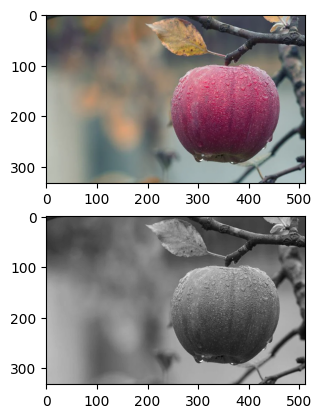

In [126]:
im1 = plt.imread('source.png')
im1_gt = plt.imread('target.png')

height, width, chs = im1.shape
# im1_gray = RGB2Gray(im1, np.array([0.299, 0.587, 0.114]))
im1_gray = RGB2Gray(im1)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(im1)
ax[1].imshow(im1_gray, cmap='gray')


### 1.b Implement a function to threshold the image by a threshold value t

In [127]:
def threshold_image(image_gray, threshold):
    
    height, width = image_gray.shape
    image_gray = image_gray.reshape((height * width))
    thresholded = np.copy(image_gray).reshape((height * width))
    thresholded[image_gray < threshold] = 0
    thresholded[image_gray >= threshold] = 1

    return thresholded.reshape((height, width))

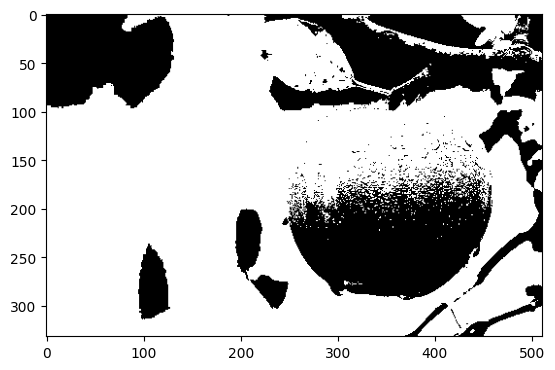

In [128]:
# test the threshold_image
plt.imshow(threshold_image(im1_gray, 0.4), cmap='gray')

### 1.c Plot the ROC curve of that method under varying t

In [129]:
def genROCCurve(image_gray, image_gt, steps=100, file_name=None, flip=False):

    assert image_gray.ndim == 2
    if image_gt.ndim == 3:
        image_gt = threshold_image(RGB2Gray(image_gt), 0.5)
    assert image_gt.ndim == 2

    height, width = image_gray.shape

    image_gt = image_gt.reshape((height * width,))
    image_gray = image_gray.reshape((height * width,))
    
    TPR = []
    FPR = []

    for threshold in range(0, steps + 1):
        threshold /= steps

        TP = np.where((image_gt>=0.5)&(image_gray>=threshold))[0].shape[0]
        FN = np.where((image_gt>=0.5)&(image_gray<threshold))[0].shape[0]
        FP = np.where((image_gt<0.5)&(image_gray>=threshold))[0].shape[0]
        TN = np.where((image_gt<0.5)&(image_gray<threshold))[0].shape[0]
        
        TPR.append(TP / (TP + FN))
        FPR.append(FP / (FP + TN))

    TPR = np.array(TPR)
    FPR = np.array(FPR)

    if flip:
        TPR, FPR = FPR, TPR

    plt.figure(figsize=(6, 4))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.plot(FPR, TPR, color='red', linewidth=1, label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='black', linewidth=1, ls='--', label='ROC Curve of Random Guess')
    plt.legend()
    if file_name:
        plt.savefig(file_name)

    return TPR, FPR

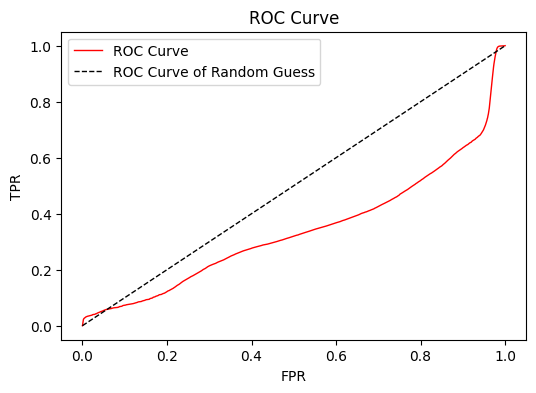

In [130]:
TPR, FPR = genROCCurve(im1_gray, im1_gt, 1000, 'ROC_Curve.jpg')

### 1.d What is the optimal threshold t, if precision and recall are weighted equally?

We can see the ROC Curve of threshold above is worse than random guess, but we can simply flip the result of thresholding so that the prediction would be better than random guess.

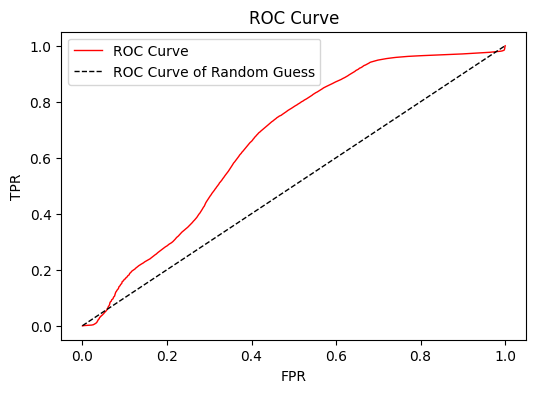

In [131]:
flipped_TPR, flipped_FPR = genROCCurve(im1_gray, im1_gt, 1000, 'Flipped_ROC_Curve.jpg', True)

In [132]:
def findBestThreshold(TPR, FPR):
    # Use Youden Index to find the best threshold

    n = TPR.shape[0] - 1
    diff = TPR - FPR
    Youden_index = np.argmax(diff)
    return TPR[Youden_index], FPR[Youden_index], Youden_index / n

Best TPR, FPR and threshold before flipped: 0.03166050155826756 0.008409757683695564 0.739
Best TPR, FPR and threshold after flipped: 0.7447808511738928 0.4618006000058253 0.394


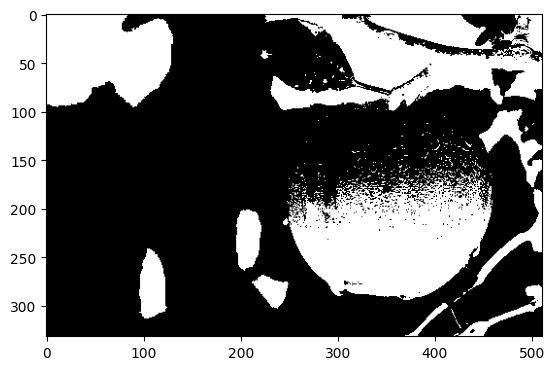

In [133]:
bTPR, bFPR, bestThreshold = findBestThreshold(TPR, FPR)
print('Best TPR, FPR and threshold before flipped:', bTPR, bFPR, bestThreshold)
b_flipped_TPR, b_flipped_FPR, best_flipped_Threshold = findBestThreshold(flipped_TPR, flipped_FPR)
print('Best TPR, FPR and threshold after flipped:', b_flipped_TPR, b_flipped_FPR, best_flipped_Threshold)
plt.imshow(1-threshold_image(im1_gray, best_flipped_Threshold), cmap='gray')

### 1.e Is there a better linear method to convert the RGB into the gray image, so that a sweep results in a better result?

Answer:

It is not very possible to get a better thresholding result by using a different liner method. In fact, the thresholding task is using a hyper plane to seperate points which represent the pixels in a image. Therefore, liner transformations like grayscaling can't reorganize the points to let a hyper plane sperate these points easier.

Code below allow us to change the weight of grayscaling and see the result.

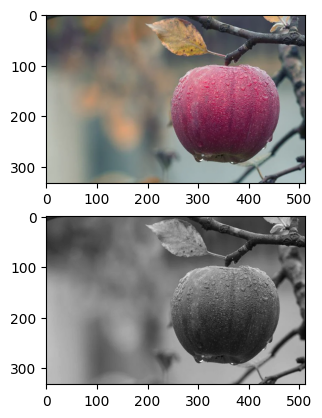

In [134]:
# Change the weight here to test.
weight = np.array([0.2126, 0.7152, 0.0722])

im1_gray2 = RGB2Gray(im1, weight)

fig, ax = plt.subplots(2, 1)
ax[0].imshow(im1)
ax[1].imshow(im1_gray2, cmap='gray')

Best TPR, FPR and threshold before flipped: 0.010165147234439169 0.003118556891493434 0.766
Best TPR, FPR and threshold after flipped: 0.8093541926854322 0.4083534791599919 0.356


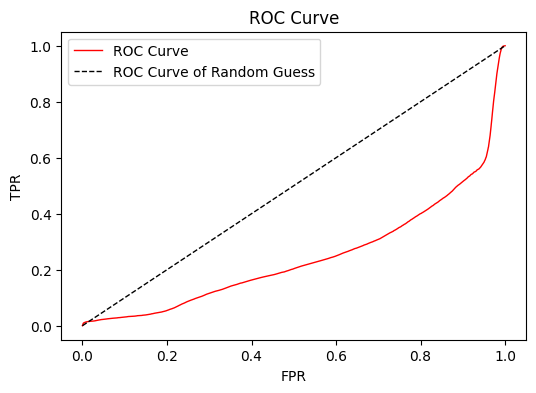

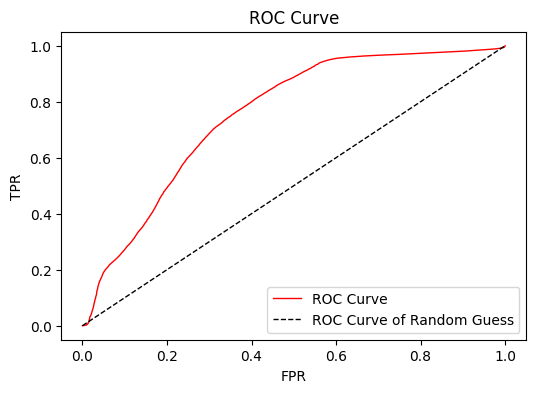

In [135]:
TPR, FPR = genROCCurve(im1_gray2, im1_gt, 1000)
flipped_TPR, flipped_FPR = genROCCurve(im1_gray2, im1_gt, 1000, None, True)
bTPR, bFPR, bestThreshold = findBestThreshold(TPR, FPR)
print('Best TPR, FPR and threshold before flipped:', bTPR, bFPR, bestThreshold)
b_flipped_TPR, b_flipped_FPR, best_flipped_Threshold = findBestThreshold(flipped_TPR, flipped_FPR)
print('Best TPR, FPR and threshold after flipped:', b_flipped_TPR, b_flipped_FPR, best_flipped_Threshold)

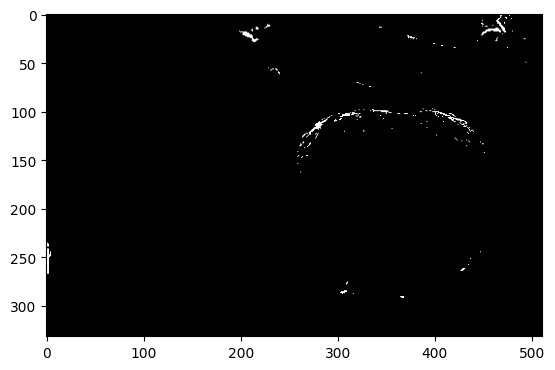

In [136]:
plt.imshow(threshold_image(im1_gray2, bestThreshold), cmap='gray')

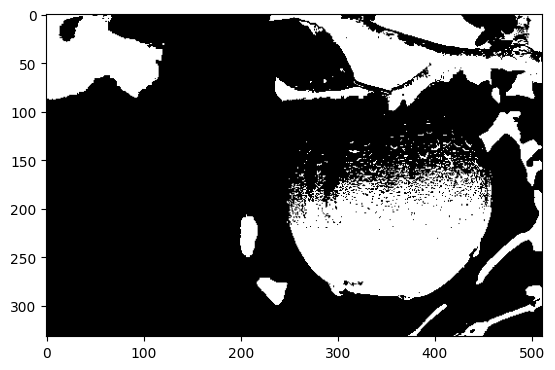

In [137]:
plt.imshow(1-threshold_image(im1_gray2, best_flipped_Threshold), cmap='gray')

## 2 Clustering
+ a. Implement a function to segment the image using k-means using only color (25 points) and using color and position (10 points) as features.
+ b. Implement a method to L2-compare the input image and its clustered version, i.e., an image where every pixel is replaced by the mean color of its cluster (10 points). Let is call this the “error”. The algorithms has free parameters: the number of clusters k for k-means <del>and the weight of the Gaussian kernel σ for mean shift</del>. 
+ c. Plot <del>four</del> two error curves for varying k <del>and σ</del> for both the color and color-and-position version of the algorithm (5 points). The horizontal axis is k <del>or σ</del>, the vertical axis is the image error.

### 2.a Implement a function to segment the image using k-means using only color and using color and position as features.

In [138]:
im2 = plt.imread('clustering.png')

In [139]:
def kmeans_rgb(I, k, max_it, use_pos=False):
    """
    Parameters
    ----------
    I: the image to be segmented (greyscale to begin with) H by W array
    k: the number of clusters (use a simple image with k=2 to begin with)
    max_it: the number of max iteration
    use_pos: whether use postion in the features or not

    Returns
    ----------
    clusters: a vector that contains the final cluster centres
    L: an array the same size as the input image that contains the label for each of the image pixels, according to which cluster it belongs
    """

    assert len(I.shape) == 3, "Wrong input dimensions! Please make sure you are using a RGB image!"

    if use_pos:
        height, width, c = I.shape
        pos = np.zeros((height, width, 2))
        for h in range(height):
            for w in range(width):
                pos[h, w] = np.array([h, w])
        I = np.concatenate((I, pos), axis=2)

    height, width, c = I.shape
    nData = height * width
    X = I.reshape((nData, c))

    # clusters = np.random.choice(X, size=(k, c), replace=False)
    clusters = np.zeros((k, c))
    clusters_idx = np.random.choice(np.array(range(nData)), size=(1,), replace=False)
    clusters[0] = X[clusters_idx[0]]
    for cc in range(1, k):
        prob = np.zeros((nData,))
        for l in range(cc):
            now_dis = np.linalg.norm(X - clusters[l], axis=1)
            prob = np.max(np.array((now_dis, prob)), axis=0)
        prob /= np.sum(prob)
        clusters_idx = np.random.choice(np.array(range(nData)), size=(1,), replace=False, p=prob)
        clusters[cc] = X[clusters_idx[0]]

    old_clusters = None
    L = np.zeros(shape=(height * width, ))
    it = 0
    while it < max_it:
        print('iter %d' % it)
        old_clusters = clusters.copy()
        dis = np.linalg.norm(X - clusters[0], axis=1)
        for i in range(1, k):
            now_dis = np.linalg.norm(X - clusters[i], axis=1)
            idx = np.where(now_dis < dis)
            dis[idx] = now_dis[idx]
            L[idx] = i
        for i in range(0, k):
            clusters[i] = np.mean(X[np.where(L == i)], axis=0)
        if (old_clusters == clusters).all():
            break
        it += 1
    return clusters, L.reshape((height, width))

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
[[0.86254877 0.6657483  0.47259131 1.        ]
 [0.26288226 0.1872317  0.07858314 1.        ]
 [0.58913851 0.4696666  0.34597996 1.        ]
 [0.41303638 0.3887496  0.15450391 1.        ]]


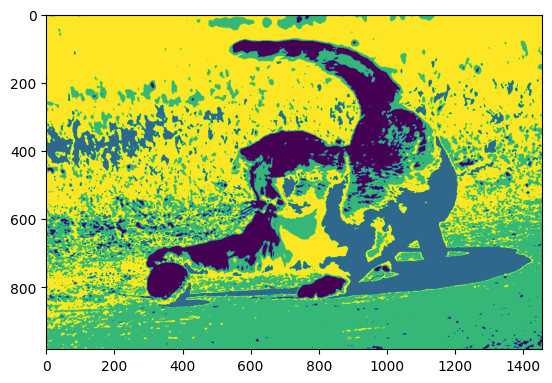

In [140]:
centroids, labels = kmeans_rgb(im2, 4, 100)
plt.imshow(labels)
print(centroids)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49
iter 50
iter 51
iter 52
iter 53
iter 54
iter 55
iter 56
iter 57
iter 58
iter 59
iter 60
iter 61
iter 62
iter 63
iter 64
iter 65
iter 66
iter 67
iter 68
iter 69
iter 70
iter 71
iter 72
iter 73
iter 74
iter 75
iter 76
iter 77
iter 78
iter 79
iter 80
iter 81
iter 82
iter 83
iter 84
iter 85
iter 86
iter 87
iter 88
iter 89
iter 90
iter 91
iter 92
iter 93
[[5.26417303e-01 4.46872981e-01 2.90569246e-01 1.00000000e+00
  7.08512190e+02 2.04903300e+02]
 [5.32699150e-01 3.99342073e-01 3.01488931e-01 1.00000000e+00
  7.64203251e+02 8.73446391e+02]
 [4.47313744e-01 4.27568315e-01 1.73097096e-01 1.00000000e+00
  2.40

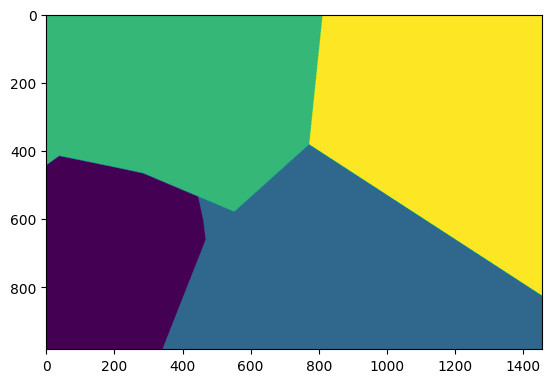

In [141]:
centroids_pos, labels_pos = kmeans_rgb(im2, 4, 100, True)
plt.imshow(labels_pos)
print(centroids_pos)

### 2.b Implement a method to L2-compare the input image and its clustered version

In [142]:
def apply_label_to_img(label, clusters, channels=4):

    height, width = label.shape
    seg_im = np.zeros((height * width, channels))
    label = label.reshape((height * width))
    k = clusters.shape[0]
    for i in range(k):
        pixel = clusters[i, :channels]
        seg_im[label==i] = pixel
    return seg_im.reshape((height, width, channels))

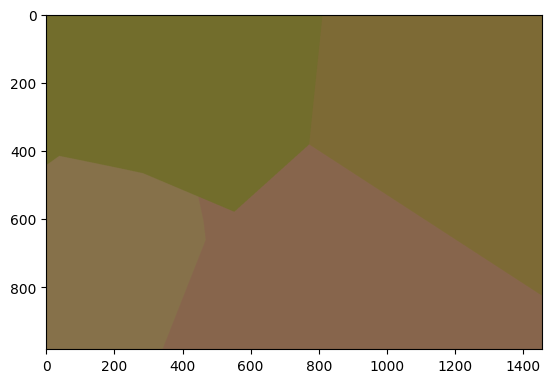

In [143]:
seg_im2 = apply_label_to_img(labels_pos, centroids_pos)
plt.imshow(seg_im2)

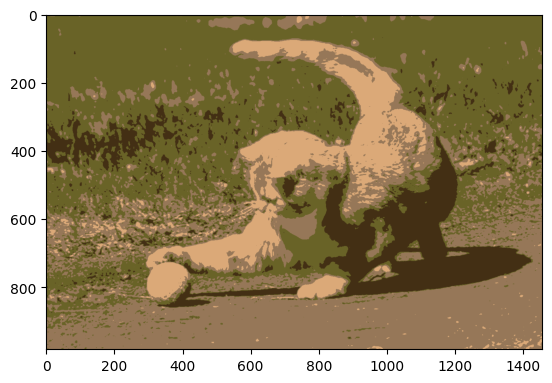

In [144]:
seg_im2_non_pos = apply_label_to_img(labels, centroids)
plt.imshow(seg_im2_non_pos)

In [145]:
def l2_compare_img(im1, im2):
    return np.linalg.norm(im1 - im2)

In [146]:
print('error of the rgb cluster:', l2_compare_img(im2, seg_im2_non_pos))
print('error of the rgb and position cluster:', l2_compare_img(im2, seg_im2))

error of the rgb cluster: 137.32858462348713
error of the rgb and position cluster: 302.15979241601053


In [147]:
def image_error_curve(image, kmax, use_pos=False):
    l2_error = []
    for k in range(2, kmax + 1):
        print('k =', k)
        centroids, labels = kmeans_rgb(image, k, 50, use_pos)
        seg_img = apply_label_to_img(labels, centroids)
        l2_error.append(l2_compare_img(seg_img, image))
    plt.figure(figsize=(6, 4))
    plt.plot(range(2, kmax + 1), l2_error, color='red', linewidth=1)

It takes about 25 minutes each to run the two code blocks below, because the k-means will become slow when the k increases. To roughly see the result, the parameter `kmax` can be set to 5 to 10.

k = 2
iter 0
iter 1
k = 3
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
k = 4
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
k = 5
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
k = 6
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter

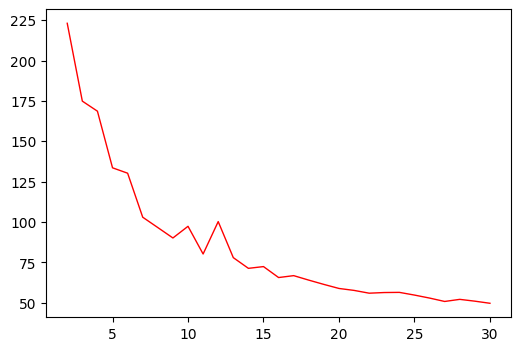

In [148]:
image_error_curve(im2, 30)

k = 2
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
k = 3
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
k = 4
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
k = 5
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
k = 6
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
ite

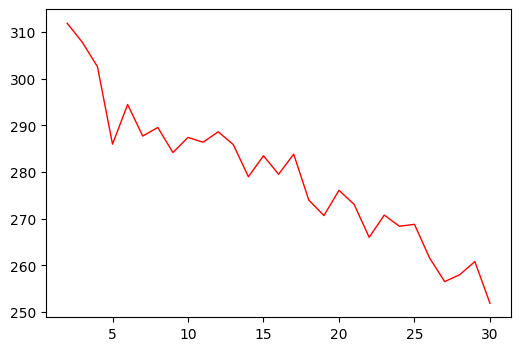

In [149]:
image_error_curve(im2, 30, True)

k = 2
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
k = 3
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
k = 4
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
k = 5
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38


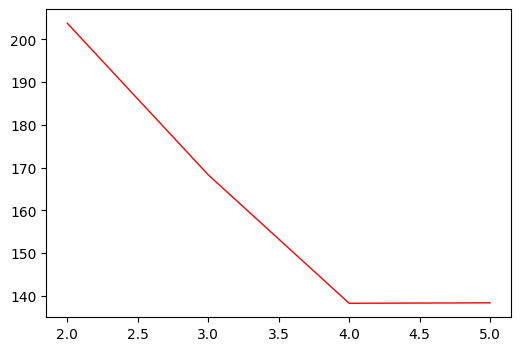

In [150]:
# Roughly see the result. About less than 1 minute.
image_error_curve(im2, 5)